In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

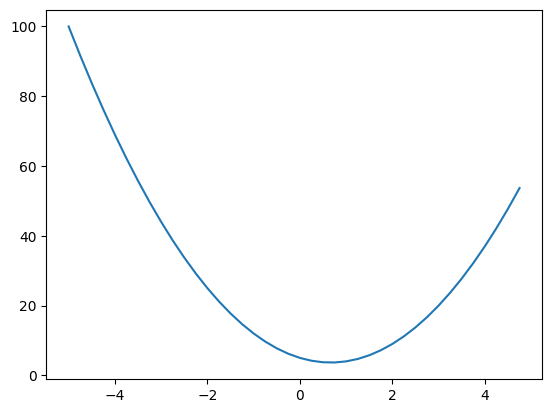

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00000001
x = 2/3
(f(x+h)-f(x))/h

0.0

In [58]:
class value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._prev = set(_children)
    self._op = _op
    self.label = label
    self._backward = lambda: None
  def __repr__(self):
    return f"Value (data = {self.data})"
  def __add__(self, other):
    out = value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward
    return out
  def __mul__(self, other):
    out = value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  def tanh(self):
    out = value(math.tanh(self.data), (self,), 'tanh')
    def _backward(): 
      self.grad += (1 - out.data**2) * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1
    for node in reversed(topo):
      node._backward()

  def reset_grad(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        v.grad = 0.0
    build_topo(self)

a = value(2.0, label='a')
b = value(-3.0, label='b')
c = value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
f = value(-2.0, label='f')
L = d * f
L.label = 'L'
L

Value (data = -8.0)

In [35]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in the graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # Left to right graph

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 

    if n._op:
      dot.node(name=uid + n._op, label= n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


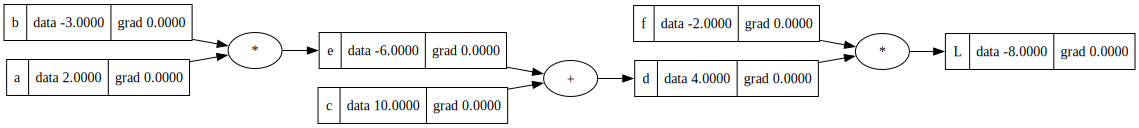

In [52]:
draw_dot(L)

In [37]:
def check_grad():
  h = 0.0001
  a = value(2.0, label='a')
  b = value(-3.0, label='b')
  c = value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L1 = L.data

  a = value(2.0, label='a')
  a.data += h
  b = value(-3.0, label='b')
  c = value(10.0, label='c')
  e = a*b
  e.label = 'e'
  d = e + c
  d.label = 'd'
  f = value(-2.0, label='f')
  L = d * f
  L.label = 'L'
  L2 = L.data
  print((L2-L1)/h)

check_grad()

6.000000000021544


In [10]:
# L.grad = 1.0
# f.grad = d.data
# d.grad = f.data
# dL/dd 
a.grad = 6.0
b.grad = -4.0

In [61]:
# inputs x1, x2
x1 = value(2.0, label='x1')
x2 = value(0, label='x2')
# weights w1, w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# draw_dot(o)

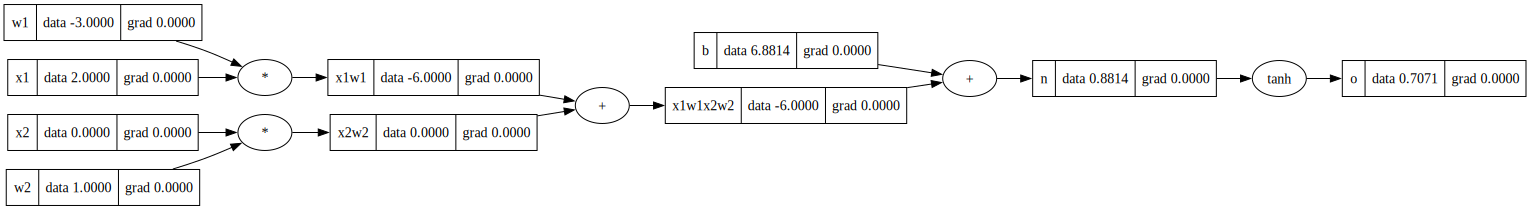

In [62]:
draw_dot(o)

Manual Gradient 

In [13]:
# o.grad = 1.0
# n.grad = (1 - o.data**2) * o.grad
# x1w1x2w2.grad = n.grad
# b.grad = n.grad
# x2w2.grad = x1w1x2w2.grad
# x1w1.grad = x1w1x2w2.grad
# x2.grad = x2w2.grad*w2.data
# w2.grad = x2w2.grad*x2.data
# x1.grad = x1w1.grad*w1.data
# w1.grad = x1w1.grad*x1.data

In [14]:
o.grad = 1.0
o._backward()

In [16]:
n._backward()

In [18]:
b._backward()
x1w1x2w2._backward()

In [20]:
x1w1._backward()
x2w2._backward()

In [22]:
w1._backward()
w2._backward()
x1._backward()
x2._backward()

In [40]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value (data = 6.881373587019543),
 Value (data = 2.0),
 Value (data = -3.0),
 Value (data = -6.0),
 Value (data = 1.0),
 Value (data = 0),
 Value (data = 0.0),
 Value (data = -6.0),
 Value (data = 0.8813735870195432),
 Value (data = 0.7071067811865476)]

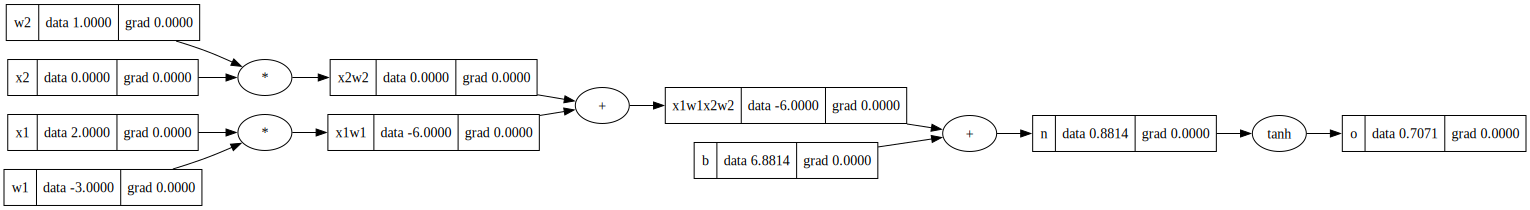

In [41]:
draw_dot(o)

In [44]:
o.grad = 1.0
for node in reversed(topo):
  node._backward()

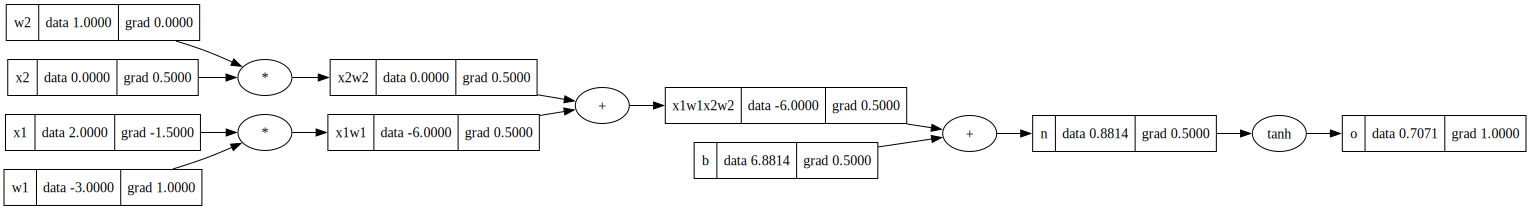

In [45]:
draw_dot(o)

In [63]:
o.backward()

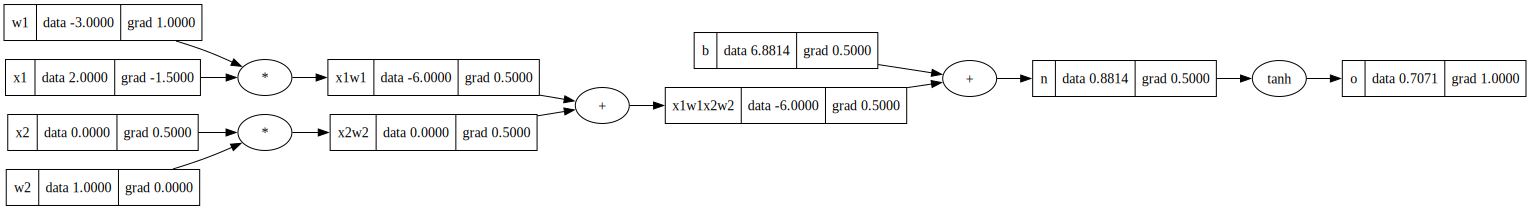

In [64]:
draw_dot(o)

In [65]:
o.reset_grad()

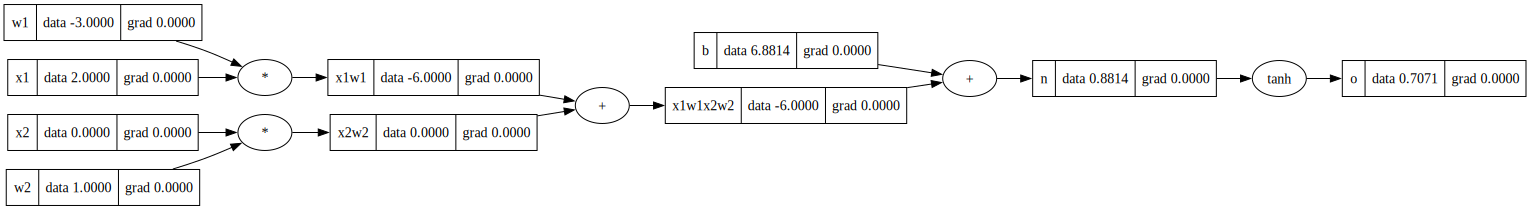

In [66]:
draw_dot(o)

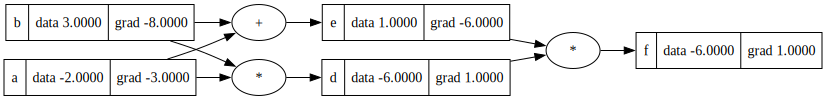

In [67]:
a = value(-2.0, label='a')
b = value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)